# Titanic: Machine Learning from Disaster - Hyperparameter Tuning
***

# Importing neccessary libraries

In [67]:
import numpy as np
import pandas as pd
from statsmodels.api import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Loading the Training data

In [2]:
df = pd.read_csv('data/train.csv')     # training set

# Data Preprocessing

In [3]:
# Dropping Attributes
df.drop(['Name', 'Cabin'], axis=1, inplace=True)

# Filling in the missing data
df.fillna({'Embarked':'Q'}, inplace=True)
df.fillna({'Age': df['Age'].median()}, inplace=True)

# Converting data into Categories
df['Sex'] = df['Sex'].astype('category')
df['Ticket'] = df['Ticket'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

# One-hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Split the dataset

In [4]:
X, y = df_encoded.drop('Survived', axis=1), df['Survived']
X = X.apply(pd.to_numeric, errors='coerce')
# Add intercept value`
X = add_constant(X)

In [5]:
# Splitting into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 690), (179, 690), (712,), (179,))

In [7]:
type(X_train)

pandas.core.frame.DataFrame

# Model

**Note**: Since the data set is small, we will only be using the `liblinear` and `lbfgs` solvers. 

In [26]:
# Function to score the classifier over metrics such as, accuracy, f1, precision, recall
def score_model(clf, clf_name, X_train, X_test, y_train, y_test):
    """
    Scores the model on metrics like accuracy, f1 score, precision, recall.

    Parameters:
    clf: BaseEstimator
        Model to be scored.
    clf_name: str
        Model name.
    X_train: pandas.core.frame.DataFrame
        Features (Training set)
    X_test: pandas.core.frame.DataFrame
        Features (Test set)
    y_train: pandas.core.frame.DataFrame
        Labels (Training Set)
    y_test: pandas.core.frame.DataFrame
        Labels (Test set)

    Returns:
    result: DataFrame
        DataFrame containing results of scores.
    """
    
    # Fit the model and make predictions
    clf.fit(X_train, y_train)

    # Get predictions
    y_preds = clf.predict(X_test)

    # Scores
    scores = {}
    scores['Accuracy'] = accuracy_score(y_test, y_preds)
    scores['F1 Score'] = f1_score(y_test, y_preds)
    scores['Precision'] = precision_score(y_test, y_preds)
    scores['Recall'] = recall_score(y_test, y_preds)

    # Result
    result = pd.DataFrame(scores, index=[clf_name])
    return result

## Using solver 'liblinear'

In [25]:
results_test = pd.DataFrame()  # Stores the scores taken against test set
results_train = pd.DataFrame() # Stores the scores taken against the training set

### Using penalty 'l1'

In [27]:
lr_l1_penalty = LogisticRegression(solver='liblinear', max_iter=5000, penalty='l1', random_state=42);
results_test = pd.concat([results_test, score_model(lr_l1_penalty, 'L1 Penalty model', X_train, X_test, y_train, y_test)])
results_train = pd.concat([results_train, score_model(lr_l1_penalty, 'L1 Penalty model', X_train, X_train, y_train, y_train)])

### Using penalty 'l2'

In [28]:
lr_l2_penalty = LogisticRegression(solver='liblinear', max_iter=5000, penalty='l2', random_state=42);
results_test = pd.concat([results_test, score_model(lr_l2_penalty, 'L2 Penalty model', X_train, X_test, y_train, y_test)])
results_train = pd.concat([results_train, score_model(lr_l2_penalty, 'L2 Penalty model', X_train, X_train, y_train, y_train)])

### Results

In [29]:
results_train # training data

,Accuracy,F1 Score,Precision,Recall
L1 Penalty model,0.825843,0.753968,0.805085,0.708955
L2 Penalty model,0.860955,0.800000,0.872247,0.738806


In [30]:
results_test # test data

,Accuracy,F1 Score,Precision,Recall
L1 Penalty model,0.810056,0.767123,0.777778,0.756757
L2 Penalty model,0.810056,0.760563,0.794118,0.729730


## Using solver 'lbfgs'

In [31]:
results_test = pd.DataFrame()  # Stores the scores taken against test set
results_train = pd.DataFrame() # Stores the scores taken against the training set

### Using penalty 'l2'

In [32]:
lr_l2_penalty = LogisticRegression(solver='lbfgs', max_iter=5000, penalty='l2', random_state=42);
results_test = pd.concat([results_test, score_model(lr_l2_penalty, 'L2 Penalty model', X_train, X_test, y_train, y_test)])
results_train = pd.concat([results_train, score_model(lr_l2_penalty, 'L2 Penalty model', X_train, X_train, y_train, y_train)])

### Using penalty 'None'

In [33]:
lr_no_penalty = LogisticRegression(solver='lbfgs', max_iter=5000, penalty=None, random_state=42);
results_test = pd.concat([results_test, score_model(lr_no_penalty, 'No Penalty model', X_train, X_test, y_train, y_test)])
results_train = pd.concat([results_train, score_model(lr_no_penalty, 'No Penalty model', X_train, X_train, y_train, y_train)])

### Results

In [35]:
results_train # training data

,Accuracy,F1 Score,Precision,Recall
L2 Penalty model,0.863764,0.805611,0.870130,0.750000
No Penalty model,0.987360,0.983240,0.981413,0.985075


In [34]:
results_test # test data

,Accuracy,F1 Score,Precision,Recall
L2 Penalty model,0.826816,0.783217,0.811594,0.756757
No Penalty model,0.810056,0.753623,0.812500,0.702703


**Observations:**
* `penalty='l2'` along with `solver='lbfgs'` appears to produce the best results. So we will continue with it.

## Parameters
- **tol**: Tolerance for stopping criteria.
- **C**: Inverse of regularization strength; must be a positive float.
- **fit_intercept**: Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
- **max_iter**: Maximum number of iterations taken for the solvers to converge.

In [41]:
param_grid = {
    'tol': [1e-4, 1e-5, 1e-6],
    'C': np.arange(0.01, 1, step=0.3),
    'fit_intercept': [True, False],
    'max_iter': np.arange(5000, 10_000, step=1000)
}

In [42]:
%%time
grid_lr = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', penalty='l2', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-2,
    error_score='raise',
    return_train_score=False
)

grid_lr.fit(X_train, y_train)

CPU times: user 29.9 s, sys: 5.45 s, total: 35.4 s
Wall time: 11min 27s


GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(random_state=42), n_jobs=-2,
             param_grid={'C': array([0.01, 0.31, 0.61, 0.91]),
                         'fit_intercept': [True, False],
                         'max_iter': array([5000, 6000, 7000, 8000, 9000]),
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='accuracy')

In [43]:
grid_lr.score(X_test, y_test)

0.8212290502793296

In [44]:
temp_df = pd.DataFrame(grid_lr.cv_results_)

In [49]:
temp_df[['params', 'mean_test_score']].T

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
params,"{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...","{'C': 0.01, 'fit_intercept': True, 'max_iter':...",...,"{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal...","{'C': 0.9099999999999999, 'fit_intercept': Fal..."
mean_test_score,0.720427,0.720427,0.720427,0.720427,0.720427,0.720427,0.720427,0.720427,0.720427,0.720427,...,0.81177,0.81177,0.81177,0.81177,0.81177,0.81177,0.81177,0.81177,0.81177,0.81177


In [51]:
grid_lr.best_score_

np.float64(0.8117797695262483)

In [52]:
grid_lr.best_estimator_

LogisticRegression(C=np.float64(0.9099999999999999), max_iter=np.int64(5000),
                   random_state=42)

**Observations:**
* The best estimator has the following parameters:
    * `solver` = _lbfgs_
    * `penalty` = _l2_
    * `C` = _0.91_
    * `max_iter` = _5000_

# Confusion Matrix

In [73]:
clf = LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    C=0.91,
    max_iter=5000,
    random_state=42
)
clf.fit(X_train, y_train);

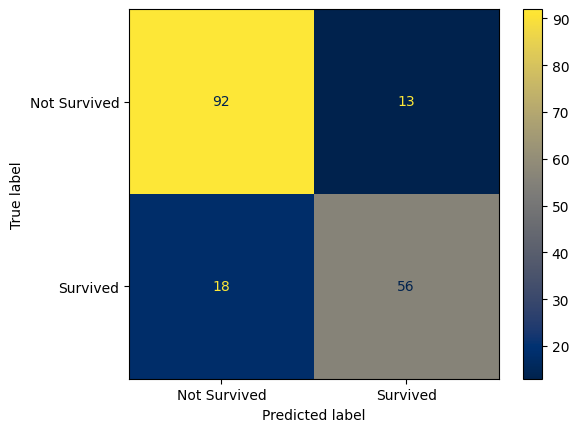

In [74]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['Not Survived', 'Survived'], cmap='cividis');

# ROC/ AUC

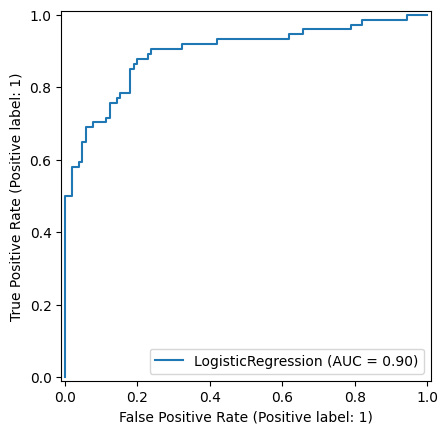

In [75]:
RocCurveDisplay.from_estimator(clf, X_test, y_test);